# Audio Classification 
GOALS: 
- Identify the number of calls made by capuchin bird in an Audio file and store in results.csv

## Install Dependencies

In [1]:
%pip install tensorflow-io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 9.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Dependencies

In [3]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import tensorflow_io as tfio

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Define Paths to File

In [5]:
file_path = '/content/drive/MyDrive/data'

In [6]:
os.listdir(file_path)

['.DS_Store',
 'Parsed_Not_Capuchinbird_Clips',
 'Parsed_Capuchinbird_Clips',
 'Forest Recordings']

In [7]:
CAPUCHIN_FILE = os.path.join(file_path,'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join(file_path, 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

### Build DataLoading Function

In [8]:
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename) # Load Encoded wav file
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) # decode wav (tensors by channel)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000) # Goes from 44100Hz ton 16000Hz - amplitude of the audio signal

    return wav

### Plot Wave

In [9]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

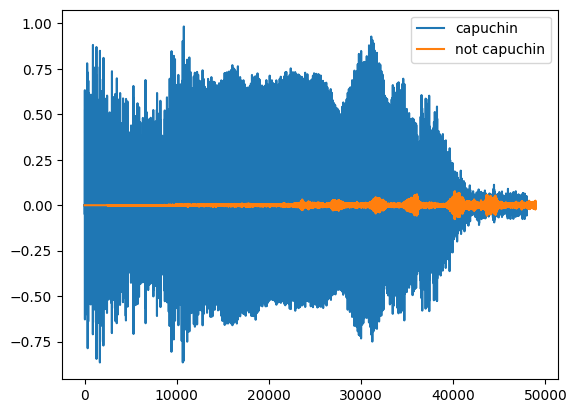

In [10]:
plt.plot(wave)
plt.plot(nwave)
plt.legend(['capuchin', 'not capuchin'])
plt.show()

Alright, We got the Audio right where we wanted, Now, We will convert the audio waves into a image representation or spectograms. So that we can use Image classification techniques on that spectograms to classify capuchin bird or non-capuchin bird.

## Create Tensorflow Dataset

In [11]:
POS = os.path.join(file_path,'Parsed_Capuchinbird_Clips')
NEG = os.path.join(file_path, 'Parsed_Not_Capuchinbird_Clips')

In [12]:
POS

'/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips'

## Create Tensorflow Datasets

In [13]:
pos = tf.data.Dataset.list_files(POS+'/*.wav', shuffle=False).map(lambda x: (x, tf.constant(1, dtype=tf.float32)))
neg = tf.data.Dataset.list_files(NEG+'/*.wav', shuffle=False).map(lambda x: (x, tf.constant(0, dtype=tf.float32)))

In [14]:
pos.as_numpy_iterator().next()

(b'/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips/XC114131-0.wav', 1.0)

## Add labels and Combine Positive and Negative samples

In [15]:
data = pos.concatenate(neg) # Combine positive and negative samples

In [16]:
data.shuffle(10000).as_numpy_iterator().next()

(b'/content/drive/MyDrive/data/Parsed_Not_Capuchinbird_Clips/crickets-sound-effect-3.wav',
 0.0)

## Determine Average Length of Capuchin Call

### Calculate Wave Cycle Length

In [17]:
lengths = []
# Analyse the distribution of audio lengths in the dataset
for file in os.listdir(POS):
  tensor_wave = load_wav_16k_mono(POS+'/'+file)
  lengths.append(len(tensor_wave))


### Calculate Mean, Min and Max

In [18]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [19]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [20]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [21]:
print("The Average length of Capuchin call is ",54202/16000,'s')
print("The Minimum length of Capuchin call is ",32000/16000,'s')
print("The Maximum length of Capuchin call is ",80000/16000,'s')

The Average length of Capuchin call is  3.387625 s
The Minimum length of Capuchin call is  2.0 s
The Maximum length of Capuchin call is  5.0 s


## Build Preprocessing Function to Convert to Spectogram

### Build Preprocessing Function

In [22]:
def preprocess(file_path, label):
  wav = load_wav_16k_mono(file_path)
  # Truncates the audio to 48000 samples(3 seconds at 16hz)
  # - This ensures consistent length of all samples
  # - If audio is shorter than 3 seconds, next steps handle padding
  wav = wav[:48000]

 # Creates zeros array of length(48000 - current_length)
 # Concatenates zeros with audio to reach exactly 48000 samplesw
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding, wav],0) # audio is right-aligned, zeros added to the left

  # Applies Short-time Fourier Transform(STFT) to convert audio to frequency domain
  # frame_length=320: Each frame is 20ms (at 16kHz)
  # frame_step=32: Frames overlap by 288 samples (90% overlap)
  spectogram = tf.signal.stft(wav,  frame_length=320, frame_step=32)

  spectogram = tf.abs(spectogram) # Take absolute value of complex STFT output to get magnitude spectogram
  spectogram = tf.expand_dims(spectogram, axis=2) # Adds a channel dimension for CNN input(shape becomes [time, freqquncy, 1])

  spectogram = tf.ensure_shape(spectogram, (1491, 257, 1))
  return spectogram, label

### Test the function and Visualize the Spectogram

In [23]:
file_path, label = pos.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [24]:
  # BEHIND THE PREPROCESS FUNCTIOn
  # wav = load_wav_16k_mono(file_path)
  # print(wav)
  # wav = wav[:48000]
  # print(wav)
  # zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
  # wav = tf.concat([zero_padding, wav],0)
  # print(wav)
  # spectogram = tf.signal.stft(wav,  frame_length=320, frame_step=32)
  # print(spectogram)
  # spectogram = tf.abs(spectogram) # Take absolute value of complex STFT output to get magnitude spectogram
  # spectogram = tf.expand_dims(spectogram, axis=2)
  # print('\n')
  # print(spectogram)

In [25]:
spectogram, label = preprocess(file_path, label)

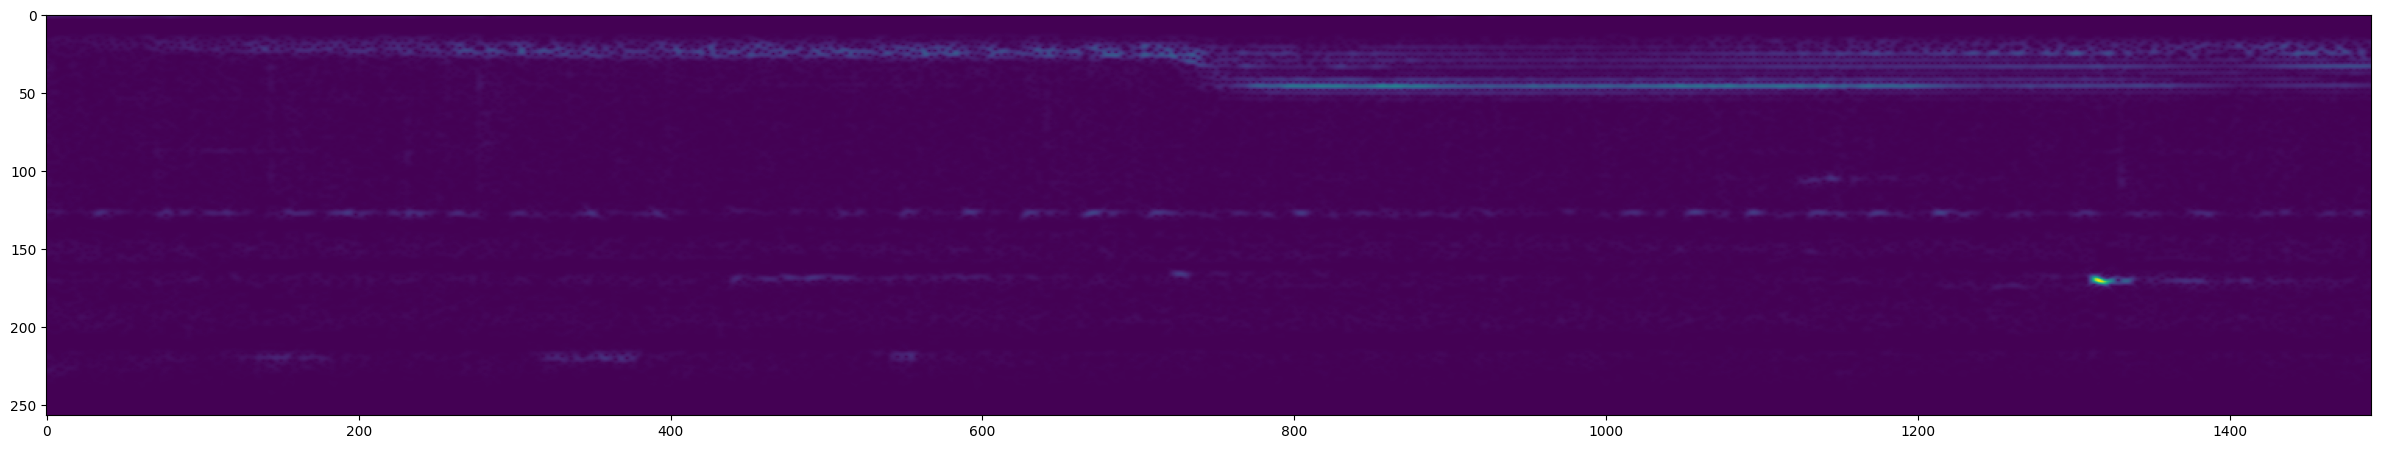

In [26]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

Congratulations! We have succesfully transformed the audio files into a spectogram.

## Creating Training and Testing Partitions

### Create a Tensorflow Data Pipeline

In [27]:
data = data.map(preprocess)
data = data.cache() # Cache the preprocessed data
data = data.shuffle(buffer_size=1000) # Shuffle the data
data = data.batch(16) # Batch the data
data = data.prefetch(8) # Prefetch data for better performance

### Split Into Training and Testing Partitions

In [28]:
train = data.take(36)
test = data.skip(36).take(15)

### Build Deep Learning Model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D

### Build Model

In [30]:
model = Sequential([
    Input(shape=(1491, 257, 1)),
    # Add MaxPooling2D to reduce dimensions
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [31]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1489, 255, 16)       │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 744, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 742, 125, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 371, 62, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 368032)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      47,108,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,110,833 (179.71 MB)

 Trainable params: 47,110,833 (179.71 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [33]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [34]:
hist = model.fit(train, epochs=5, validation_data=test)

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 165s 180ms/step - loss: 1.3576 - precision: 0.7428 - recall: 0.8333 - val_loss: 0.0756 - val_precision: 0.9831 - val_recall: 0.8788
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - loss: 0.0413 - precision: 0.9974 - recall: 0.9427 - val_loss: 0.0186 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0268 - precision: 0.9955 - recall: 0.9886 - val_loss: 0.0245 - val_precision: 0.9853 - val_recall: 0.9853
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0120 - precision: 1.0000 - recall: 0.9914 - val_loss: 0.0026 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0077 - precision: 0.9960 - recall: 0.9976 - val_loss: 0.0037 - val_precision: 1.0000 - val_recall: 1.0000


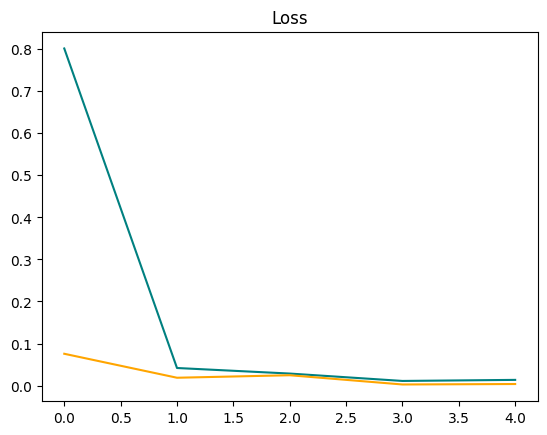

In [35]:
plt.title('Loss')
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.show()

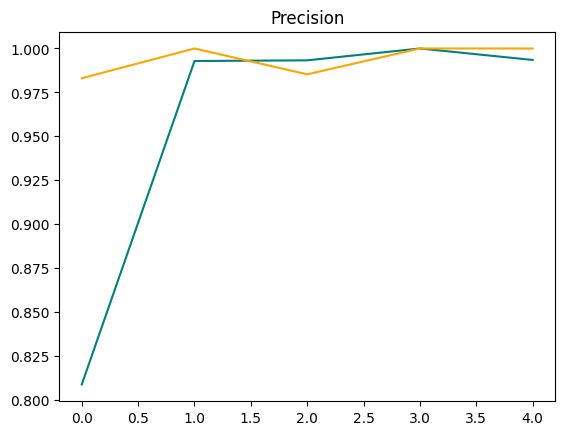

In [36]:
plt.title('Precision')
plt.plot(hist.history['precision'], color='teal', label='precision')
plt.plot(hist.history['val_precision'], color='orange', label='val_precision')
plt.show()

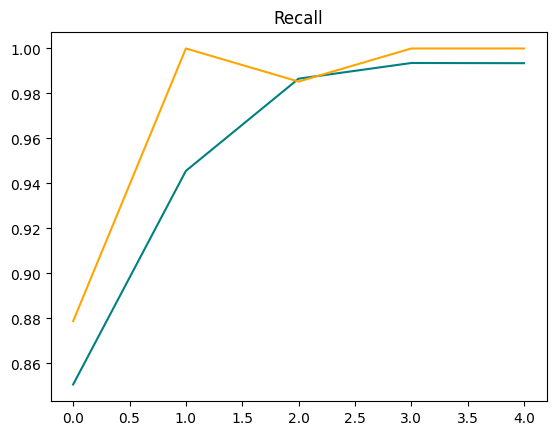

In [37]:
plt.title('Recall')
plt.plot(hist.history['recall'], color='teal', label='recall')
plt.plot(hist.history['val_recall'], color='orange', label='val_recall')
plt.show()

## Make a Prediction on a Single Clip

### Get one Batch and Make a Prediction


In [38]:
X_test, y_test = test.as_numpy_iterator().next()

In [39]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


### Convert Logits to Probabilities

In [40]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat

[0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]

In [41]:
y_test.astype(int)

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0])

So, We can see that our Model successfully predicted correct Labels. Another Checkpoint !!

## Build Forest Parsing Functions

### Load Up MP3

In [42]:
def load_mp3_16k_mono(filename):
    """ Load a MP3 file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Combine to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2

    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    # Resample to 16hz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav


In [43]:
file_path = '/content/drive/MyDrive/data'

In [44]:
wav = load_mp3_16k_mono(os.path.join(file_path, 'Forest Recordings', 'recording_00.mp3'))

In [45]:
print(wav, len(wav))

tf.Tensor(
[ 8.1433272e-12 -5.7019250e-12 -5.3486417e-12 ... -1.1291276e-02
 -1.4230422e-02 -3.0555837e-03], shape=(2880666,), dtype=float32) 2880666


In [46]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(
    wav, # raw audio data as input
    wav, # using same audio data for targets
    sequence_length=48000, # This parameter defines the length (in samples) of each individual audio segment your dataset will be divided into. If your wav data is at a 48kHz sample rate, this means each segment is 1 second long.
    sequence_stride=48000,  # This determines the step size (in samples) between consecutive segments. With a stride equal to the sequence length, you're creating non-overlapping segments.
    batch_size=1 # # Processing one segment at a time
)

In [47]:
samples, index = audio_slices.as_numpy_iterator().next()

In [48]:
print(len(audio_slices))

60


### Build Function to Convert Clips into Windowed Spectograms

In [49]:
def preprocess_mp3(sample, index):
  sample = sample[0]
  zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
  wav = tf.concat([zero_padding, sample],0)

  spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectogram = tf.abs(spectogram)
  spectogram = tf.expand_dims(spectogram, axis=2)
  return spectogram

### Convert Longer Clips into Windows and Make Predictions

In [50]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [51]:
yhat = model.predict(audio_slices)
yhat =  [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [52]:
len(yhat)

60

In [53]:
yhat

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

### Group Consecutive Detections

In [54]:
from itertools import groupby

In [55]:
yhat = [key for key, group in groupby(yhat)]
print(yhat)
calls = tf.math.reduce_sum(yhat).numpy()
print(calls)

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
5


HOORAY!. That was a lot but we`re now successfully able to detect the number of capuchin bird calls in the audio. Now, Let`s do it for the whole dataset.

In [56]:
results = {}

In [57]:
for file in os.listdir(os.path.join(file_path, 'Forest Recordings')):
  FILEPATH = os.path.join(file_path, 'Forest Recordings', file)

  wav = load_mp3_16k_mono(FILEPATH)
  audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
  audio_slices = audio_slices.map(preprocess_mp3)
  audio_slices = audio_slices.batch(64)

  yhat = model.predict(audio_slices)

  results[file] = yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

## Convert Predictions into Classes

In [61]:
class_preds = {}
for file, logits in results.items():
  class_preds[file] = [1 if pred > 0.99 else 0 for pred in logits]
class_preds['recording_00.mp3']

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

### Group Consecutive Detections

In [63]:
postprocessed = {}
for file, scores in class_preds.items():
  postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()

postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 24,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 17,
 'recording_19.mp3': 0,
 'recording_18.mp3': 3,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_27.mp3': 0,
 'recording_26.mp3': 2,
 'recording_25.mp3': 3,
 'recording_24.mp3': 0,
 'recording_29.mp3': 0,
 'recording_28.mp3': 6,
 'recording_31.mp3': 1,
 'recording_30.mp3': 3,
 'recording_32.mp3': 2,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_33.mp3': 0,
 'recording_38.mp3': 19,
 'recording_37.mp3': 3,
 'recording_36.mp3': 0,
 'recording_42.mp3': 0,
 'recording_41.mp3': 0,
 'recording_3

### Export Results

In [64]:
import csv

with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])